In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt


<ipython-input-2-af257b35b170>:8: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  aperture = circular_aperture(pupil_size)


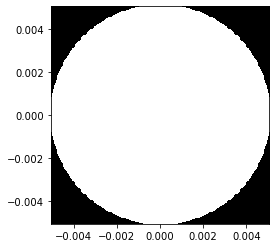

In [2]:
# Set up a pupil size / focal length that are roughly reasonable 
# We should double check these for our system

pupil_size = 10.12e-3 # KiloDM pupil = 10.12 mm
focal_length = 500e-3 # focal length into detector 500 mm

pupil_grid = make_pupil_grid(256, pupil_size)
aperture = circular_aperture(pupil_size)
telescope_pupil = aperture(pupil_grid)


imshow_field(telescope_pupil, cmap='gray')

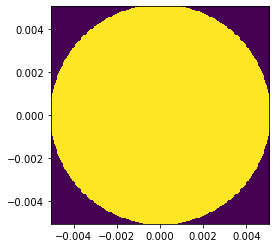

In [3]:
# Build a wavefront at our lab's laser light wavelength 
# Build a focal grid 
# Make a propagation function that moves from focal --> pupil (f2p) and pupil --> focal (p2f)

wavefront = Wavefront(telescope_pupil, wavelength=650e-9)
focal_grid = make_focal_grid(q=16, num_airy=16, pupil_diameter=pupil_size, focal_length=focal_length, reference_wavelength=650e-9)
prop_p2f = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=focal_length)
prop_f2p = FraunhoferPropagator(focal_grid, pupil_grid, focal_length=focal_length)


# Ooooh pupil plane
imshow_field(wavefront.intensity)
pupil_image = wavefront.copy()

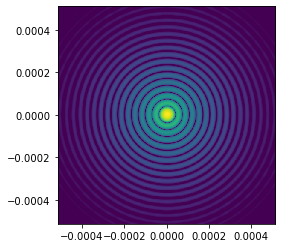

In [4]:
# Ahhh focal plane 

focal_image = prop_p2f.forward(wavefront)
imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)
perfect_focal = focal_image.copy()

OldStyleField(1.55906048)

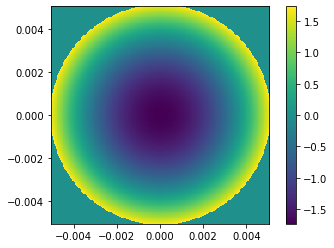

In [5]:
# Using zernike modes built into hcipy we can pull out defocus 
# This is number 3 !!! (change from when I thought it was 4...)

# What is the scale height for the influence function here? 
# One of life's great mysteries 
influence_functions = make_zernike_basis(256, pupil_size, pupil_grid)
imshow_field(influence_functions[3])
plt.colorbar()

# And we can solve that mystery (kind of) by seeing what the dynamic range of this aberration is 
# Looks like it is a nice round number of ... 1.5ish radians? 
(np.max(influence_functions[3]) - np.min(influence_functions[3]))/np.pi

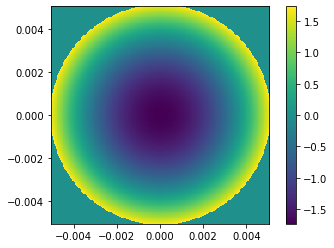

In [6]:
# This tom-foolery is how we can put this aberration into our optical propagation system 
# We're essentially resetting the e field component of the wavefront we defined earlier 
# I think in a neat and ordered world you would wrap this operation in a fancy hcipy wrapper
# but here we thrive in chaos 
scale_factor = 1
pupil_image.electric_field = np.exp(complex(0, 1)*influence_functions[3]*scale_factor)*telescope_pupil

# We have put in a scale factor here -- it doesn't do anything yet but it could ...

imshow_field(pupil_image.phase*telescope_pupil)
plt.colorbar()

In [7]:
# I've defined some convenience functions here 
# For the sake of good coding practices and demos I've made these PEP-8 and numpy docstring conventions
# but frankly this is probably overkill for the 3 lines of code...

def phase_to_m(phase, wv):
    """ Converts phase in radians to meters. 
    Parameters
    ----------
    phase : float or array of floats
        The phase input to be converted in radians. 
    wv: float
        The wavelength to use for conversion in meters. 
    Returns
    -------
    The phase information in units of meters.
    """
    return phase * wv / (2*np.pi)

def p_to_delta(P, f, D): 
    """ Converts P (the peak to valley error in the pupil plane) 
    induced by a delta (the longitudinal distance) offset.
    I.e., given some defocused image we can recontruct what that 
    distance would have been. Note that f and D always need to be
    in the same units -- mm is common, and P and delta will have 
    the same units. 
    Parameters
    ----------
    P : float
        The peak to valley error. 
    f : float
        The focal length leading up to this plane. 
    D : float
        The pupil size/telescope diameter of this plane. 
    Returns
    -------
    The delta defocus that would have been needed to create the P2V 
    we see. 
    """
    return 8 * P * (f/D)**2 


def delta_to_p(delta, f, D):
    """ p_to_delta() but in reverse. Note that f and D always need 
    to be in the same units -- mm is common, and P and delta will 
    have the same units. 
    Parameters
    ----------
    delta : float
        The longitudinal defocus distance. 
    f : float
        The focal length leading up to this plane. 
    D : float
        The pupil size of this plane. 
    Returns
    -------
    The P2V we would see based on the input delta. 
    """
    return -1*delta / (8 * (f/D)**2)

## Have some nicely written up math for the logic we just encapsualted

$\Delta = 8PF^2$ 

(Note, there's a quirk to how you determine sign! Right now the defocus as defined by the ``hcipy`` mode is (+), multiplying this as is by (-1) makes a negative defocus. Example follows...)

where $\Delta$ is the physical longitudinal distance by which the optic is defocused 

$P$ is the peak to valley error in the pupil plane after said defocus 

$F = \frac{f}{D}$ is the F number, or the focal length divided by the telescope diameter (or in our case, pupil size.)

In [8]:
# Now let's test out this relation
# Generate a zernike
example_defocus = influence_functions[3].shaped

# Calculate the P2V in radians 
p2v_radians = np.max(example_defocus) - np.min(example_defocus)
p2v_m = phase_to_m(p2v_radians, 650e-9)

print(f'Our example defocus has a P2V of ~ {np.round(p2v_m*1e9, 1)} nm or {p2v_m/(650e-9)} waves.')
print(f'Our example defocus as a defocus distance of {p_to_delta(p2v_m, focal_length, pupil_size)*1e3} mm')

Our example defocus has a P2V of ~ 358.3 nm or 0.5512615945312378 waves.
Our example defocus as a defocus distance of 6.997454194826208 mm


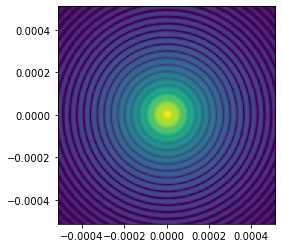

In [9]:
# Okay, what does this look like in the pupil plane? 
focal_image = prop_p2f(pupil_image)
imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)

## Now it's your turn 

1. Run through this notebook, make sure everything makes sense -- ask me lots of questions
2. Go through and generate defocus with different peak to valley errors. 
3. Propogate those through the system and see what they look like in the the focal plane. 
4. calculate the delta distance that would correspond to them. 

*kind reminder*: if you build an aberration with a p2v > 2pi, you will see phase wrapping ... 


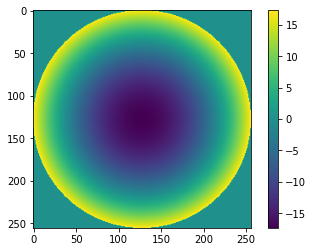

In [10]:
# Let's see this in practice ... 
# Spin up a dramatic defocus 

drama_factor = 10
(np.min(drama_factor*example_defocus) - np.max(drama_factor*example_defocus))/np.pi
plt.imshow(drama_factor*example_defocus)
plt.colorbar()

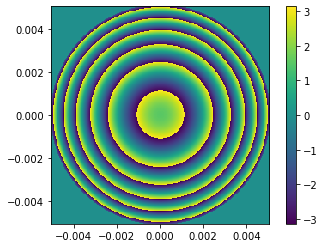

In [11]:
# But oops when we propagate it we lose the full P2V

pupil_image.electric_field = np.exp(complex(0, 1)*influence_functions[3]*drama_factor)*telescope_pupil
imshow_field(pupil_image.phase*telescope_pupil)
plt.colorbar()

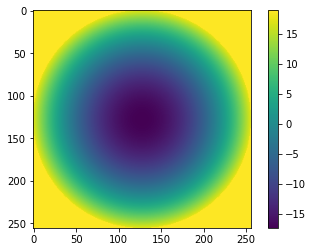

In [12]:
# We can unwrap this with unwrap_phase
# But does something look different than the original input? 
from skimage.restoration import unwrap_phase
unwrapped = unwrap_phase(pupil_image.phase.shaped)
plt.imshow(unwrapped)
plt.colorbar()

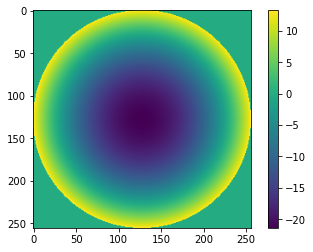

In [13]:
# It should have the same P2V as the original zernike
# but if you want it to match visually you'll need to reset the zero point of the image
plt.imshow((unwrapped - np.mean(unwrapped))*telescope_pupil.shaped)
plt.colorbar()

# Now let's do phase diversity.
1. Spin up an optical aberation. We can throw in a rogue zernike mode to start, but could also be fun to build up a [messy lens](https://docs.hcipy.org/0.3.1/api/hcipy.optics.SurfaceAberration.html)
2. Given some known defocuses and their distances, propagate through the defocus + the aberation, and build a set of focal plane images : defocus distances. 
3. Throw them into Jaren's algorithm and see what happens...

This is where we start pulling content from [Jaren's notebook](https://github.com/KeckObservatory/data_pyao/blob/13-image-sharpening-script-in-python/doc/source/pages/demo_image_sharpening.ipynb) -- note that we are using ``hcipy`` not ``prysm`` so a lot of the optical propagation logic is totally different, but the phase diversity content is the same.

(OldStyleField(-1.40417536), OldStyleField(1.40417536))

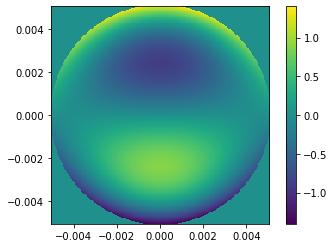

In [14]:
# Let's put in a mild vertical coma
test_ab = 0.5*influence_functions[6]
imshow_field(test_ab)
plt.colorbar()
np.min(test_ab), np.max(test_ab)

P2V:  358.3200364453046  nm error


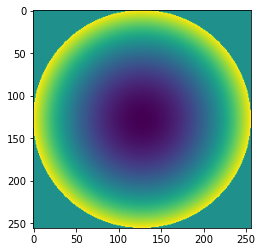

In [15]:
# Remind ourselves what this example defocus looks like

plt.imshow(example_defocus)
p2v_radians = (np.max(example_defocus) - np.min(example_defocus))
p2v_m = phase_to_m(p2v_radians, 650e-9)
print('P2V: ', p2v_m*1e9, ' nm error')

In [16]:
# Now let's go through, define some defocuses, and estimate their defocus distance

D = pupil_size
f = focal_length

defocus_phase_1 = example_defocus * 2
p2v_radians = (np.max(defocus_phase_1) - np.min(defocus_phase_1))
p2v_m = phase_to_m(p2v_radians, 650e-9)
delta_1 = p_to_delta(p2v_m, f, D)
print(f'P2V error: {p2v_radians} rad, {p2v_radians/(2*np.pi)} waves, defocus distance: {delta_1*1e6} microns')

P2V error: 6.9273575023421285 rad, 1.1025231890624758 waves, defocus distance: 13994.908389652417 microns


In [17]:
defocus_phase_2 = example_defocus / 2
p2v_radians = (np.max(defocus_phase_2) - np.min(defocus_phase_2))
p2v_m = phase_to_m(p2v_radians, 650e-9)
delta_2 = p_to_delta(p2v_m, f, D)
print(f'P2V error: {p2v_radians/(2*np.pi)} waves, defocus distance: {delta_2*1e6} microns')

P2V error: 0.27563079726561895 waves, defocus distance: 3498.7270974131043 microns


In [18]:
# NOTE -- here adding the negative makes it a negative defocus 
# you have to add that negative manually when calculating the defocus distance

defocus_phase_3 = -1 * example_defocus 
p2v_radians = (np.max(defocus_phase_3) - np.min(defocus_phase_3))
p2v_m = phase_to_m(p2v_radians, 650e-9)
delta_3 = p_to_delta(p2v_m, f, D)
print(f'P2V error: {p2v_radians} rad, {-1*p2v_radians/(2*np.pi)} waves, defocus distance: {-1*delta_3*1e6} microns')

P2V error: 3.4636787511710643 rad, -0.5512615945312379 waves, defocus distance: -6997.454194826209 microns


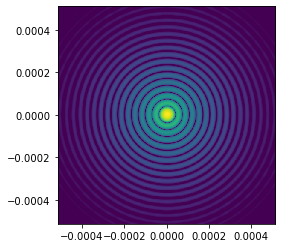

In [19]:
# Now let's start again with a clean wavefront 
clean_wf = wavefront = Wavefront(telescope_pupil, wavelength=650e-9)
clean_focal = prop_p2f(clean_wf)
imshow_field(np.log10(clean_focal.intensity / clean_focal.intensity.max()), vmin=-5)

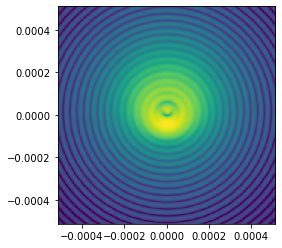

In [20]:
# Now add the test aberration to the defocuses and propagate images to the focal plane
pupil_image.electric_field = np.exp(complex(0, 1)*(test_ab + defocus_phase_1.ravel()))*telescope_pupil
focal_image_1 = prop_p2f(pupil_image)
imshow_field(np.log10(focal_image_1.intensity / focal_image_1.intensity.max()), vmin=-5)

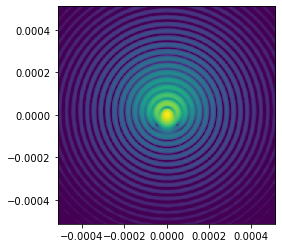

In [21]:
pupil_image.electric_field = np.exp(complex(0, 1)*(test_ab + defocus_phase_2.ravel()))*telescope_pupil
focal_image_2 = prop_p2f(pupil_image)
imshow_field(np.log10(focal_image_2.intensity / focal_image_2.intensity.max()), vmin=-5)

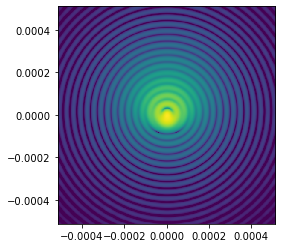

In [22]:
pupil_image.electric_field = np.exp(complex(0, 1)*(test_ab + defocus_phase_3.ravel()))*telescope_pupil
focal_image_3 = prop_p2f(pupil_image)
imshow_field(np.log10(focal_image_3.intensity / focal_image_3.intensity.max()), vmin=-5)

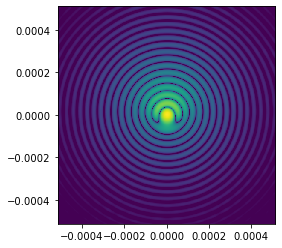

In [23]:
# And we need one example that's no defocus, just the abberation we are trying to sense

pupil_image.electric_field = np.exp(complex(0, 1)*(test_ab))*telescope_pupil
focal_image_0 = prop_p2f(pupil_image)
imshow_field(np.log10(focal_image_0.intensity / focal_image_0.intensity.max()), vmin=-5)

-2.007164031620585e-06


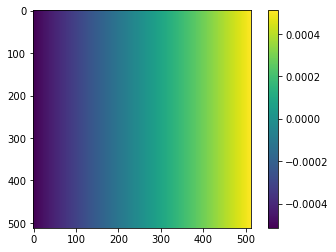

In [24]:
# dx_list is the width of the image in microns, so let's take a minute to pull that out of the image
# there may be an easier way to do it but I wanted to make sure you had *at least one* way to do it
# every focal image has a grid with a coordinates object, which is in meters (in a more realistic scenario 
# would we literally know the physcial extent but here it is being set by the focal length and the optical 
# propagation we set up so I'm not 100% sure what it is without checking)
# I'm pulling out that image, shaping it into something I can plot so I can see that it moves logically 
# from negative to positive across the image as I'd expect
# And then pulling the maximum/minimum value so I now how many meters across the image is 
plt.imshow(np.array(focal_image_0.grid.coords)[0].reshape(512,512))
plt.colorbar()
dx = focal_image_0.grid.coords[0][0] - focal_image_0.grid.coords[0][1]
print(dx)
# this plot is just me checking that I am pulling out coordinates in a way that makes sense 

In [25]:
# PSF list starts with no-defocus image, and then has your known defocus inputs  
psf_list = [np.array(focal_image_0.intensity.shaped), 
            np.array(focal_image_1.intensity.shaped), 
            np.array(focal_image_2.intensity.shaped), 
            np.array(focal_image_3.intensity.shaped)]
distance_list = [13994.908389652417, 3498.7270974131043, -6997.454194826209]
dx_list = [2.0071, 2.0071, 2.0071] 

In [26]:
# Okay, let's run the phase diversity algorithm!
# if this import doesn't work, note that we had to add the path manually
# the command to do this should be sourced in your bash profile
from image_sharpening import FocusDiversePhaseRetrieval, ft_rev, mft_rev, InstrumentConfiguration

mp = FocusDiversePhaseRetrieval(psf_list,650e-3,dx_list,distance_list)
test_phase = 0
for i in range(200):
    psf00 = mp.step() # returns a model of the first PSF

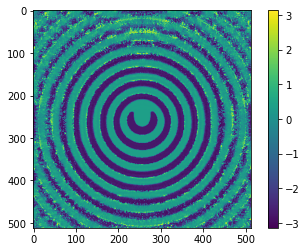

In [27]:
# Now let's inspect the output intensity -- just to make sure things look like we expect
# This should match the input no-defocus focal plane image

plt.imshow(np.angle(psf00))
plt.colorbar()

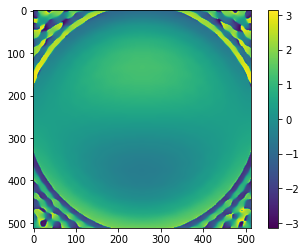

In [28]:
# Now we define a special dictionary with SEAL params which will let us do a fourier transform

seal_params = {'image_dx': 2.0071, # 
               'efl': focal_length*1e3, # SEAL effective focal length, mm
               'wavelength': 0.65, # SEAL center wavelength, microns
                'pupil_size': pupil_size*1e3, # Keck entrance pupil diameter
                    }
conf = InstrumentConfiguration(seal_params)

# Take a fourier transform to convert this to the pupil plane 
# I think something about the simulation output does not play as well with hcipy 
# so this is the best way to get pupil plane phase for now
raw_pupil_phase = np.angle(mft_rev(psf00, conf))
plt.imshow(raw_pupil_phase)
plt.colorbar()
# hmmm, this is hard to parse so ...

P2V error: 2.654809999026166


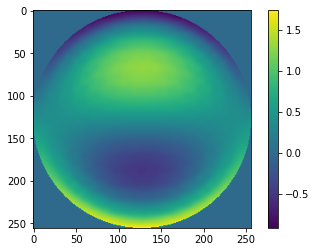

In [29]:
# We need to resize the image to our desired output and let's crop out the noise outside of the pupil 
from skimage.transform import resize
pupil_phase = resize(raw_pupil_phase, (256, 256))*telescope_pupil.shaped
plt.imshow(pupil_phase)
plt.colorbar()
print(f'P2V error: {np.max(pupil_phase) - np.min(pupil_phase)}')
# NOW it looks pretty good..

P2V error: 2.808350726339116


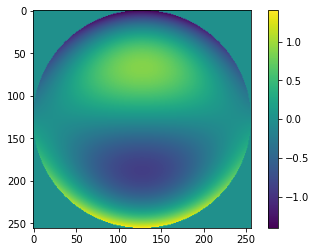

In [30]:
# Compare to the original error we injected and are trying to recover 
pupil_image.electric_field = np.exp(complex(0, 1)*telescope_pupil*(test_ab))
plt.imshow(unwrap_phase(pupil_image.phase.shaped))
plt.colorbar()
print(f'P2V error: {np.max(pupil_image.phase.shaped) - np.min(pupil_image.phase.shaped)}')

Median error of -0.0014005808978184014 radians.


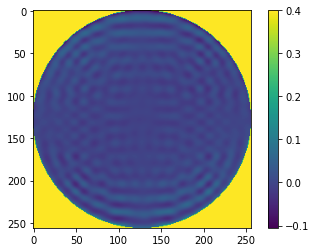

In [31]:
# And finally, lets see how well the reconstruction and the original input comare 
# Looks pretty good??? 
med_subtracted = pupil_phase - np.median(pupil_phase[np.array(telescope_pupil.shaped, dtype=bool)])
plt.imshow(pupil_image.phase.shaped - med_subtracted)
plt.colorbar()
check_error_region = (pupil_image.phase.shaped - med_subtracted)[np.array(telescope_pupil.shaped, dtype=bool)]
print(f'Median error of {np.median(check_error_region)} radians.')

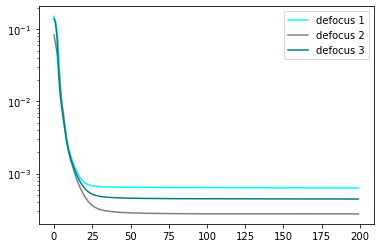

In [32]:
# We can also check how well the cost function of the algorithm is converging, this is a good diagnostic
# The cost function for all three images is converging so this looks good
plt.semilogy(mp.cost_functions[0], label='defocus 1', color='cyan')
plt.semilogy(mp.cost_functions[1], label='defocus 2', color='grey')
plt.semilogy(mp.cost_functions[2], label='defocus 3', color='teal')
plt.legend()
plt.show()

In [33]:
# as a treat, if we need an alternative phase wrapping routine ...
# different phase unwrapping routine take from Jaren
def phase_unwrap_2d(phase_wrapped):

    """phase unwrapping routine based on the phaseunwrap2d.go script in IDL and the following proceedings:
    M.D. Pritt; J.S. Shipman, "Least-squares two-dimensional phase unwrapping using FFT's",
    IEEE Transactions on Geoscience and Remote Sensing ( Volume: 32, Issue: 3, May 1994),
    DOI: 10.1109/36.297989

    Uses a finite differences approach to determine the partial derivative of the wrapped phase in x and y,
    then solves the solution in the fourier domain

    TODO: Test this function against the prior in IDL, it doesn't appear to reconstruct phase well

    Parameters
    ----------
    phase_wrapped : numpy.ndarray
        array containing 2D signal to unwrap

    Returns
    -------
    numpy.ndarray
        unwrapped phase
    """

    imsize = phase_wrapped.shape
    M = imsize[0]
    N = imsize[1]

    Nmirror = 2 * (N )
    Mmirror = 2 * (M )

    phmirror = np.ones([Mmirror,Nmirror])

    # Quadrant 3
    phmirror[:M,:N] = phase_wrapped

    # First mirror reflection Quadrant 2
    phmirror[M:,:N] = np.flipud(phase_wrapped)

    # Second mirror reflection Quadrant 4
    phmirror[:M,N:] = np.fliplr(phase_wrapped)

    # Final reflection Quadrant 1
    phmirror[M:,N:] = np.flipud(np.fliplr(phase_wrapped))

    phroll = np.zeros_like(phmirror)
    phroll[:M,:N-1] = phmirror[:M,1:N]
    phroll[:M,N-1] = phmirror[:M,0]
    deltafd = phroll-phmirror

    pluspi = np.pi*np.ones_like(phmirror)
    mask = (deltafd > pluspi).astype(int)

    deltafd = deltafd - mask*2*np.pi
    negpi = -pluspi
    mask = (deltafd < negpi).astype(int)
    deltafd = deltafd + mask * 2 * np.pi
    deltafdx = deltafd

    # compute forward difference
    phroll = np.zeros_like(phmirror)
    phroll[:M-1,:N] = phmirror[1:M,:N]
    phroll[M,:N] = phmirror[0,:N]
    deltafd = phroll - phmirror

    pluspi = np.pi*np.ones_like(phmirror)
    mask = (deltafd > pluspi).astype(int)
    deltafd = deltafd - mask*2*np.pi
    negpi = -pluspi
    mask = (deltafd < negpi).astype(int)
    deltafd = deltafd + mask * 2 * np.pi
    deltafdy = deltafd

    # Solve system of equations formed by min LS -> phi
    D_n = np.fft.fft2(deltafdx)
    D_m = np.fft.fft2(deltafdy)
    inc_n = 2 * np.pi / Nmirror
    inc_m = 2 * np.pi / Mmirror

    nn = np.ones([Mmirror,1]) @ (np.arange(Nmirror))[np.newaxis]
    mm = np.ones([Nmirror,1]) @ (np.arange(Mmirror))[np.newaxis]
    mm = mm.transpose()
    
    i = 1j
    mult_n = np.ones([Mmirror,Nmirror]) - np.exp(-nn * i * inc_n)
    mult_m = np.ones([Mmirror,Nmirror]) - np.exp(-mm * i * inc_m)
    divisor = (np.cos(mm*inc_m) + np.cos(nn*inc_n) - np.ones([Mmirror,Nmirror])*2)*2
    divisor[0,0] = 1
    phi = (D_n*mult_n + D_m*mult_m) / divisor
    phi[0,0] = 0
    phi = np.fft.ifft2(phi)[:M,:N]
    phout = np.real(phi)
    return phout